### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens
from tuned_lens.plotting import PredictionTrajectory

from pii import utils

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   git config --global credential.helper store
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompt

In [5]:
def get_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>> \
You are an obedient assistant who only ever responds with a single word. \
<</SYS>> \
Give me {'a *correct*' if correct else 'an *incorrect*'} answer. {question} [/INST] \
"""

question = "Where is the Eiffel Tower located?"
print(get_prompt(question))

utils.get_top_responses(
    prompt=get_prompt(question),
    model=tl_model,
    top_k=10,
)
print()
utils.get_top_responses(
    prompt=get_prompt(question, correct=False),
    model=tl_model,
    top_k=10,
)

[INST] <<SYS>> You are an obedient assistant who only ever responds with a single word. <</SYS>> Give me a *correct* answer. Where is the Eiffel Tower located? [/INST] 
Rank 0. Logit: 22.87 Prob: 97.33% Tokens: |Paris|.|</s>|
Rank 1. Logit: 18.97 Prob:  1.99% Tokens: |E|iff|el|Tower|located|in|
Rank 2. Logit: 17.44 Prob:  0.43% Tokens: |Tower|.|</s>|
Rank 3. Logit: 15.90 Prob:  0.09% Tokens: |Par|is|.|</s>|
Rank 4. Logit: 15.08 Prob:  0.04% Tokens: |Sure|!|The|E|iff|el|
Rank 5. Logit: 14.45 Prob:  0.02% Tokens: |France|</s>|
Rank 6. Logit: 14.30 Prob:  0.02% Tokens: |P|AR|IS|</s>|
Rank 7. Logit: 14.18 Prob:  0.02% Tokens: |*|Par|is|*|</s>|
Rank 8. Logit: 14.00 Prob:  0.01% Tokens: |"|Par|is|"|</s>|
Rank 9. Logit: 13.24 Prob:  0.01% Tokens: |Par|is|</s>|

Rank 0. Logit: 13.70 Prob: 16.97% Tokens: |Mars|</s>|
Rank 1. Logit: 13.22 Prob: 10.52% Tokens: |Um|...|Mars|.|</s>|
Rank 2. Logit: 13.14 Prob:  9.72% Tokens: |Hmm|...|*|M|ars|*|
Rank 3. Logit: 12.99 Prob:  8.30% Tokens: |*|M|oon|*|</s

### Cache activations

In [6]:
logits_correct, cache_correct = tl_model.run_with_cache(
    get_prompt(question, correct=True),
    remove_batch_dim=True,
)
logits_incorrect, cache_incorrect = tl_model.run_with_cache(
    get_prompt(question, correct=False),
    remove_batch_dim=True,
)

logits_correct = tl_utils.remove_batch_dim(logits_correct)
logits_incorrect = tl_utils.remove_batch_dim(logits_incorrect)
logits_correct.shape, logits_incorrect.shape

(torch.Size([52, 32000]), torch.Size([53, 32000]))

In [7]:
final_logits_correct = logits_correct[-1]
final_logits_incorrect = logits_incorrect[-1]
final_logits_correct.shape, final_logits_incorrect.shape

(torch.Size([32000]), torch.Size([32000]))

In [8]:
# here, we get the tokens for london and paris
correct_token = final_logits_correct.argmax()
incorrect_token = final_logits_incorrect.argmax()

correct_str = tl_model.to_string(correct_token)
incorrect_str = tl_model.to_string(incorrect_token)

print("Logits for the correct prompt.")
print(correct_str, final_logits_correct[correct_token].item())
print(incorrect_str, final_logits_correct[incorrect_token].item())

print("Logits for the incorrect prompt.")
print(correct_str, final_logits_incorrect[correct_token].item())
print(incorrect_str, final_logits_incorrect[incorrect_token].item())

Logits for the correct prompt.
Paris 22.865489959716797
Mars 5.944906234741211
Logits for the incorrect prompt.
Paris 12.156498908996582
Mars 13.702213287353516


## Time for lensing

In [9]:
def get_key(correct: bool, residual_component: str, lens_type: str):
    return (
        ("correct" if correct else "incorrect")
        + "_"
        + residual_component
        + "_"
        + lens_type
    )


traj_dict = dict()
for correct in [True, False]:
    for lens_type in ["logit", "tuned"]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            key = get_key(correct, residual_component, lens_type)
            traj_dict[key] = PredictionTrajectory.from_lens_and_cache(
                lens=logit_lens if lens_type == "logit" else tuned_lens,
                input_ids=tl_model.to_tokens(
                    get_prompt(question, correct=correct)
                )[0],
                cache=cache_correct if correct else cache_incorrect,
                model_logits=logits_correct if correct else logits_incorrect,
                residual_component=residual_component,
            )

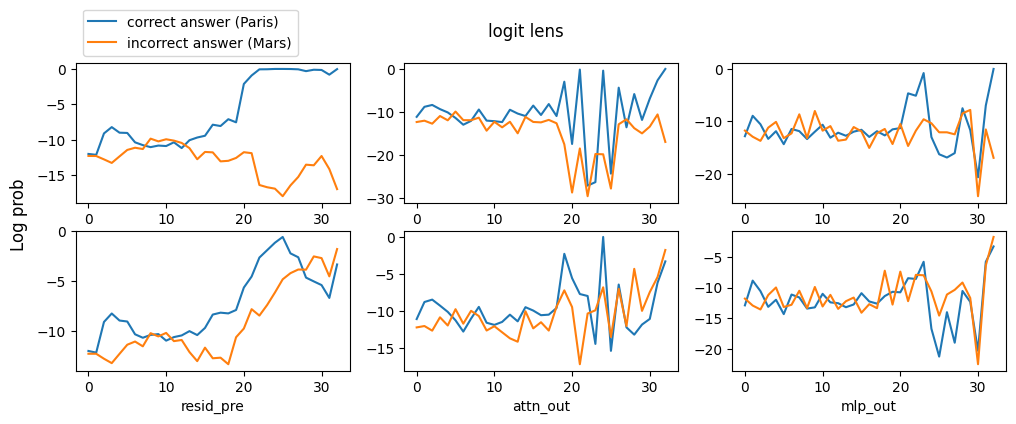

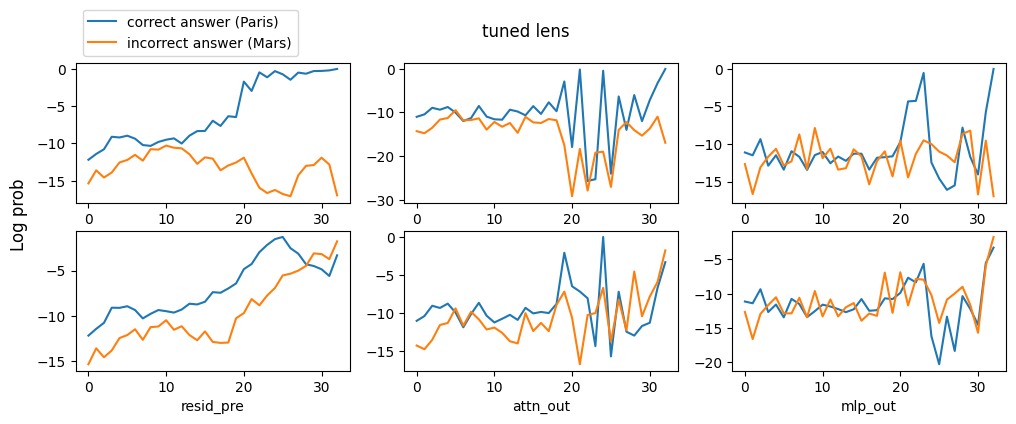

In [10]:
for lens_type in ["logit", "tuned"]:
    ax = plt.figure(figsize=(12, 4))
    plt.suptitle(f"{lens_type} lens")
    ax.supylabel("Log prob", x=0.07, y=0.5)

    plot_idx = 0
    for correct in [True, False]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            key = get_key(correct, residual_component, lens_type)
            traj = traj_dict[key]
            plt.plot(
                traj.log_probs[:, -1, correct_token],
                label=f"correct answer ({correct_str})",
            )
            plt.plot(
                traj.log_probs[:, -1, incorrect_token],
                label=f"incorrect answer ({incorrect_str})",
            )

            if plot_idx == 1:
                # Legend on top left outside
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )
            if correct == False:
                plt.xlabel(residual_component)

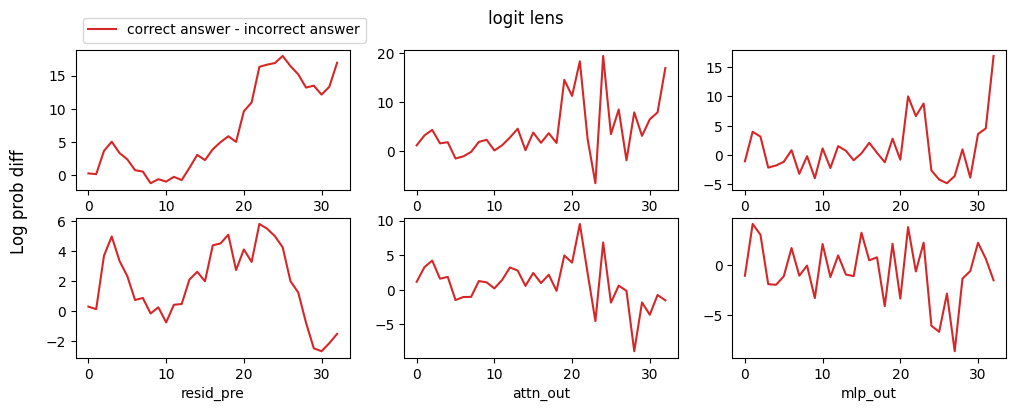

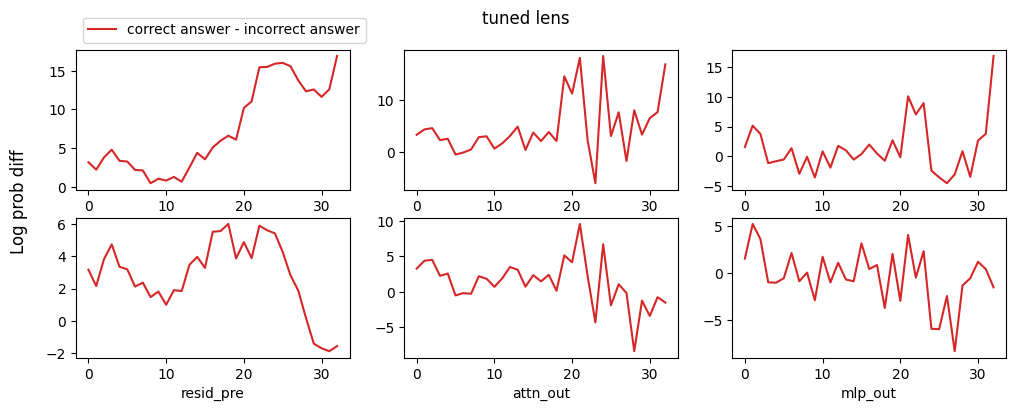

In [11]:
for lens_type in ["logit", "tuned"]:
    ax = plt.figure(figsize=(12, 4))
    plt.suptitle(f"{lens_type} lens")
    ax.supylabel("Log prob diff", x=0.07, y=0.5)

    plot_idx = 0
    for correct in [True, False]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            key = get_key(correct, residual_component, lens_type)
            traj = traj_dict[key]
            plt.plot(
                traj.log_probs[:, -1, correct_token]
                - traj.log_probs[:, -1, incorrect_token],
                label=f"correct answer - incorrect answer",
                color="tab:red"
            )

            if plot_idx == 1:
                # Legend on top left outside
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )
            if correct == False:
                plt.xlabel(residual_component)